<a href="https://colab.research.google.com/github/xxKamilxx/Covid19_lungs_segmentation/blob/main/Covid19_lungs_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!cp "/content/drive/MyDrive/covid_lungs/covid-segmentation.zip" /content/

In [3]:
from zipfile import ZipFile

file_name = "/content/covid-segmentation.zip"

with ZipFile(file_name, "r") as zp:
  zp.printdir()
  print("Extracting all the files now")
  zp.extractall("/content/data_train")
  print("done!")

File Name                                             Modified             Size
images_medseg.npy                              2020-05-14 20:04:00    209715328
images_radiopedia.npy                          2020-05-14 20:04:28   1738539136
masks_medseg.npy                               2020-05-14 20:06:48    104857728
masks_radiopedia.npy                           2020-05-14 20:06:52    869269632
test_images_medseg.npy                         2020-05-14 20:07:26     20971648
Extracting all the files now
done!


In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import albumentations as A
import cv2

In [ ]:
print(torch.__version__) 

In [5]:
prefix = '/content/data_train/'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

# test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

In [10]:

# from albumentations.pytorch import ToTensorV2

class Lungs_dataset(Dataset):
  def __init__(self,images,masks,flag):
    self.images=images
    self.masks=masks
    self.flag=flag

    
    if self.flag=='train':
      self.train_augs = A.Compose([
         A.Resize(256,256),                          
        A.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
        # A.RandomSizedCrop((int(512 * 0.75),512), 
        #                               222, 
        #                               222, 
        #                               interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.Normalize(  mean=[0.485],
        # std=[0.229]),
        # ToTensorV2()

        ])
    else:
      self.valid_augs = A.Compose([
         A.Resize(256,256),
        #  A.Normalize( mean=[0.485],
        # std=[0.229]),
        # ToTensorV2()
        ])


  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self,idx):
    if self.flag=='train':
      image=self.images[idx,...]
      mask=self.masks[idx,...]
      sample = self.train_augs(image=image/255, mask=mask)
      image, mask = sample['image'], sample['mask']
      return image,mask[:,:,:3]
    else:
      image=self.images[idx,...]
      mask=self.masks[idx,...]
      sample = self.valid_augs(image=image/255, mask=mask)
      image, mask = sample['image'], sample['mask']
      return image,mask[:,:,:3]
    



In [11]:
images_train=np.concatenate((images_medseg[32:], images_radiopedia))
masks_train=np.concatenate((masks_medseg[32:], masks_radiopedia))

images_valid=images_medseg[:32]
masks_valid=masks_medseg[:32]

In [12]:
print(images_train.shape)
print(images_valid.shape)

(897, 512, 512, 1)
(32, 512, 512, 1)


In [13]:
train_data=Lungs_dataset(images_train,masks_train,'train')
valid_data=Lungs_dataset(images_valid,masks_valid,'valid')

In [14]:
train_dataloader=DataLoader(train_data,batch_size=32,shuffle=True)
valid_dataloader=DataLoader(valid_data,batch_size=32,shuffle=True)

In [15]:
image,mask =next(iter(train_dataloader))


In [16]:
image.shape

torch.Size([32, 256, 256, 1])

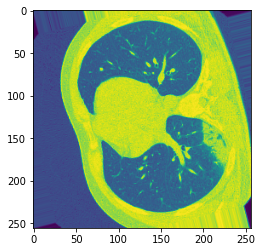

In [17]:
plt.imshow(image[0,:,:,0])

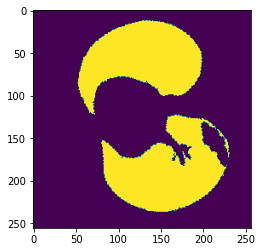

In [18]:
plt.imshow(mask[0,:,:,2])

In [19]:
!pip install segmentation-models-pytorch

In [20]:
from efficientnet_pytorch import EfficientNet
import segmentation_models_pytorch as smp
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.optim import lr_scheduler

base_model=smp.Unet(
    encoder_name="efficientnet-b0",      
    encoder_weights="imagenet",   
    in_channels=3,                 
    classes=3, 
    activation='sigmoid'
)

model=nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=3,kernel_size=1),
    base_model)




Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


In [ ]:
import tqdm
from tqdm.auto import tqdm as tq
import torch
import shutil

def train(epoch):
  train_loss=0.0
  model.train()
  bar_train = tq(train_dataloader, postfix={"train_loss":0.0})
  for i in range(250):
    image,mask =next(iter(train_dataloader))
    image,mask=image.permute(0,3,1,2),mask.permute(0,3,1,2)
    image,mask=torch.tensor(image).cuda(), torch.tensor(mask, requires_grad=False).long().cuda()
   
    optimizer.zero_grad()

    output=model.forward(image)
  
    loss1=criterion(output[:,0,:,:],mask[:,0,:,:])
    loss2=criterion(output[:,1,:,:],mask[:,1,:,:])
    loss3=criterion(output[:,2,:,:],mask[:,2,:,:])
    loss=loss1+loss2+loss3
    loss.backward()

    optimizer.step()
    # clip_grad_norm_(model.parameters(), 5.0)
    train_loss+=loss.item()
    bar_train.set_postfix(ordered_dict={"train_loss":loss.item()})
  print(f"Epoch:{epoch}, step {i}, traning loss: {train_loss/(i+1)}") 

def validation(epoch):
  valid_loss=0.0
  model.eval()
  bar_val=tq(valid_dataloader,postfix={
                                    "valid_loss":0.0,
                                    "IoU_score1":0.0,
                                    "IoU_score2":0.0,
                                    "IoU_score3":0.0  
                                     })
  with torch.no_grad():
    for image,mask in bar_val:
      image,mask=image.permute(0,3,1,2),mask.permute(0,3,1,2)
      image,mask=torch.tensor(image).cuda(), torch.tensor(mask, requires_grad=False).long().cuda()
     
 
      output=model.forward(image)
  
      loss1=criterion(output[:,0,:,:],mask[:,0,:,:])
      loss2=criterion(output[:,1,:,:],mask[:,1,:,:])
      loss3=criterion(output[:,2,:,:],mask[:,2,:,:])
      loss=loss1+loss2+loss3

      
      iou_score1=iou_pytorch(output[:,0,:,:],mask[:,0,:,:])
      iou_score2=iou_pytorch(output[:,1,:,:],mask[:,1,:,:])
      iou_score3=iou_pytorch(output[:,2,:,:],mask[:,2,:,:])
      # print(iou_score1)

      valid_loss+=loss.item()
      bar_val.set_postfix(ordered_dict={"valid_loss":loss.item(),
                                    "IoU_score1":iou_score1,
                                    "IoU_score2":iou_score2,
                                    "IoU_score3":iou_score3,
                                   })
  return valid_loss 
    

def saver_fn(net_params, is_best=0, name='/content/drive/My Drive/covid_lungs/fix_checkpt.pth.tar'):
    torch.save(net_params, name)

    if is_best is not None:
        shutil.copyfile(name, '/content/drive/My Drive/covid_lungs/fix_best_.pth.tar')


model=model.cuda()

iou_pytorch=smp.utils.metrics.IoU()
criterion=smp.utils.losses.DiceLoss()
optimizer=Adam(model.parameters(), lr = 0.005)
scheduler=lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.2,patience=8,verbose=1)

epochs=100
new_val_loss=2.0
is_best=0
for epoch in range(epochs):

  train(epoch)
  valid_loss=validation(epoch)

  scheduler.step(valid_loss)

  if new_val_loss > valid_loss:
      new_val_loss = valid_loss
      is_best = epoch + 1

  saver_fn({
      'epoch': epoch + 1,
      'state_dict': model.state_dict(),
      'best_val_loss': valid_loss,
      'optimizer': optimizer.state_dict(),
      # 'learning_rate': optimizer.l
  }, is_best)
  

In [22]:
state_dict=torch.load("/content/drive/MyDrive/covid_lungs/fix_checkpt.pth.tar")['state_dict']

model.load_state_dict(state_dict)

<All keys matched successfully>

In [23]:
image,mask =next(iter(train_dataloader))
image,mask=image.permute(0,3,1,2),mask.permute(0,3,1,2)
image,mask=torch.tensor(image).cuda(), torch.tensor(mask, requires_grad=False).long().cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
model=model.cuda()
output=model.forward(image)

In [25]:
output.shape

torch.Size([32, 3, 256, 256])

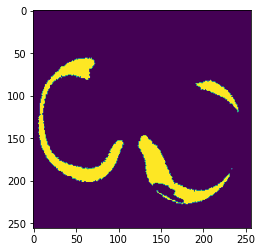

In [26]:
mask=mask.detach().cpu()
plt.imshow(mask[0,2,:,:])

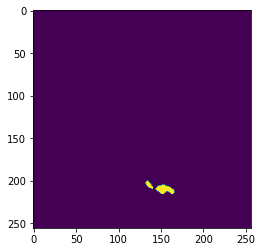

In [27]:
output=output.detach().cpu()
plt.imshow(output[0,1,:,:]>0.5)

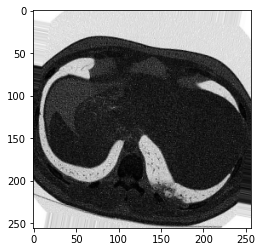

In [28]:
image=image.detach().cpu()
plt.imshow(image[0,0,:,:],cmap='Greys')

In [44]:
outp=output[0,1,:,:]>0.5
outp=outp.detach().cpu().numpy().astype(np.uint8)
im=image[0,0,:,:]
im=im.numpy().astype(np.float32)

In [45]:
img = cv2.merge((im,im,im))
out=cv2.merge((outp,outp,outp))
print(img.shape,out.shape)

(256, 256, 3) (256, 256, 3)


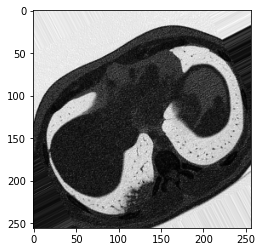

In [67]:
plt.imshow(img[:,:,0]*255,cmap='Greys')

In [57]:
color_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [47]:
print(img.max(),image[0,0,:,:].max())

0.52054006 tensor(0.5205)


In [58]:
import cv2
ou=outp*255
edges = cv2.Canny(ou,50,200)

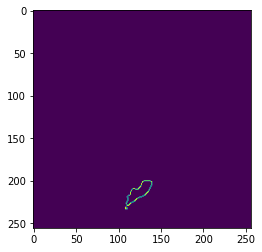

In [59]:
plt.imshow(edges)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


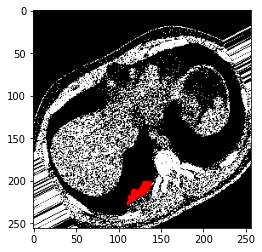

In [72]:
# dst = np.uint8(0.5*(im)+0.5*(outp))
img2=img.copy()*255
img2[outp==1]=[255,0,0]
plt.imshow(img2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


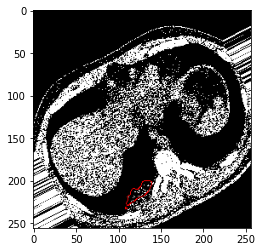

In [51]:
img3=img.copy()*255
img3[edges==255]=[255,0,0]
plt.imshow(img3)

In [74]:
image.shape

torch.Size([32, 1, 256, 256])

In [ ]:
def visualisation(images, masks,preds, num_samples=8):
  num_classes=masks.shape[1]
  fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(20,10))
  for i in range(num_samples):
    ax[0,i].imshow(images[i,0,:,:],cmap='Greys')
    for j in range(num_classes):
      ax[1+j,i].imshow(masks[i,j,:,:],vmin=0, vmax=1)
                    
      # mask_to_show = np.zeros(shape=(256,256, 3)) 
      # mask_to_show[..., 0] = preds[i,:,:,j] > 0.5
      # mask_to_show[..., 1] = mask_batch[i,:,:,j]
      # ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
      # ax[j + 1, i].set_xticks([]) 
      # ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()
 
  plt.show()


visualisation(images_radiopedia[30:], masks_radiopedia[30:],output[30:], num_samples=8)

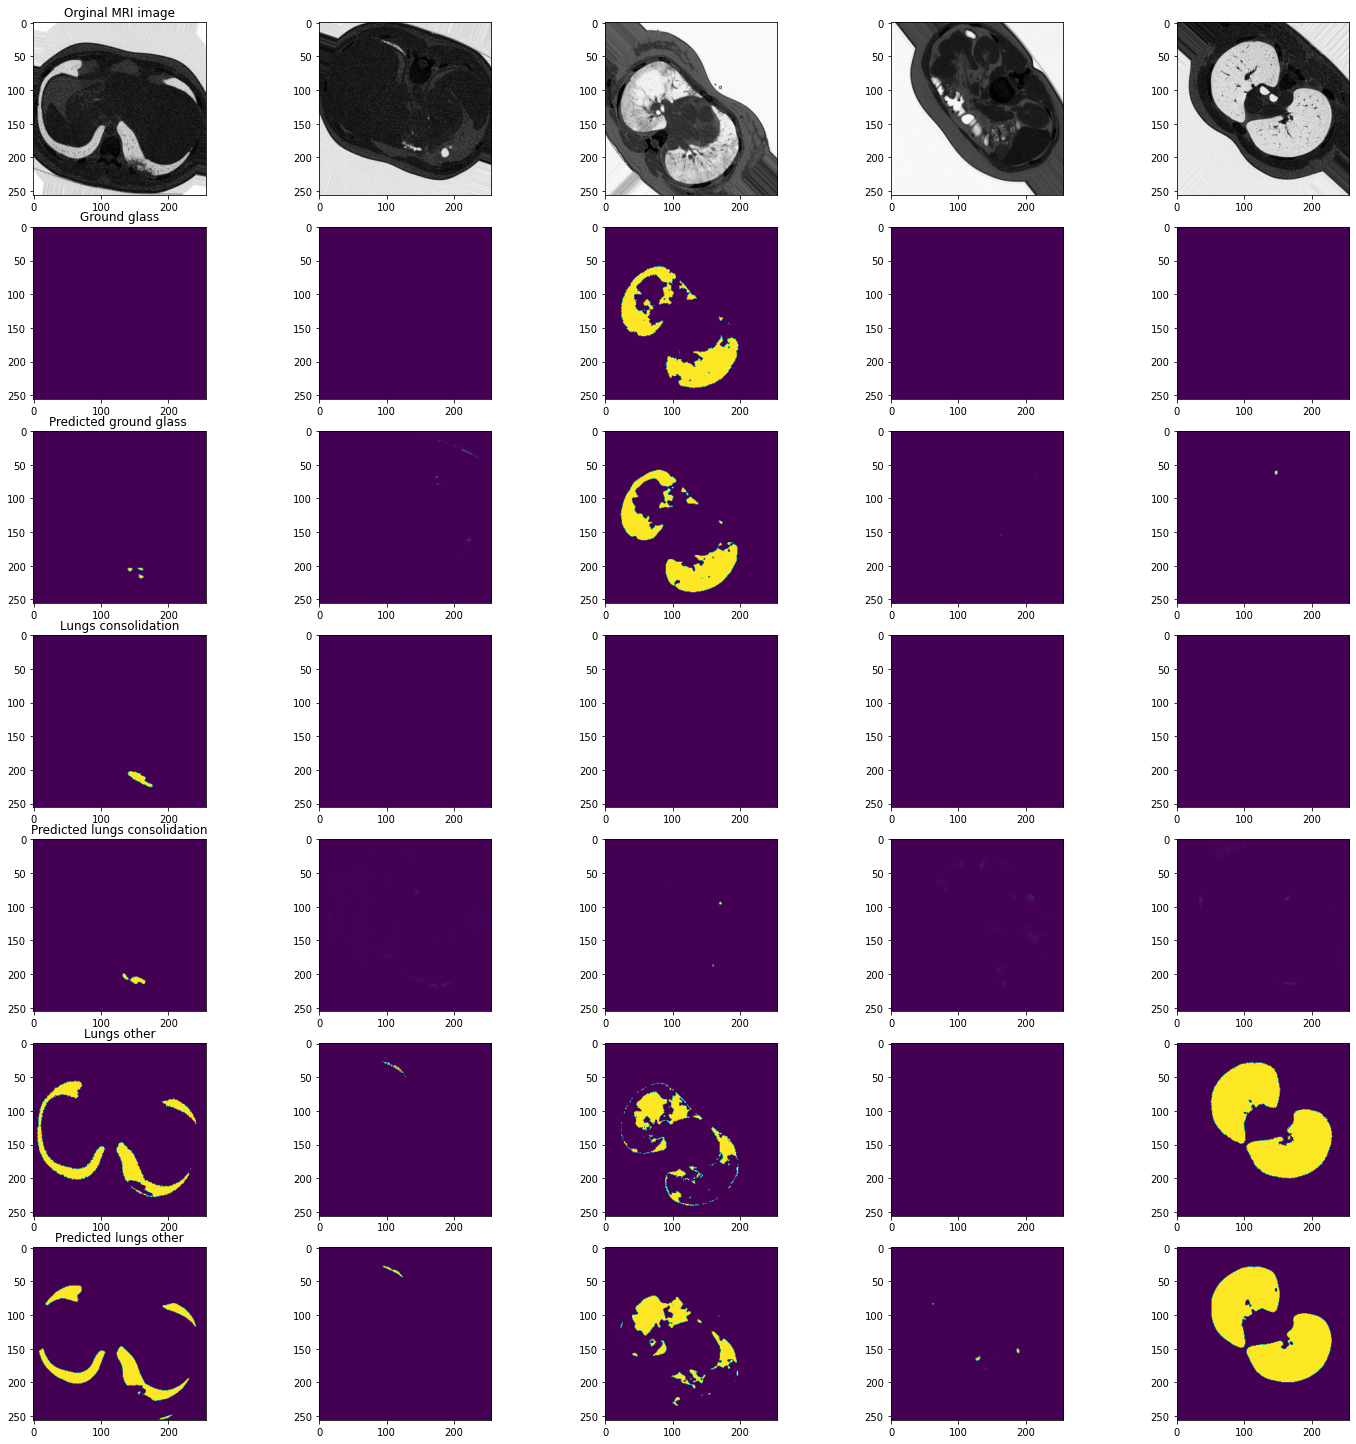

In [49]:

fig, ax = plt.subplots(7, 5, figsize=(20,20))
fig.tight_layout()
for i in range(5):
  
  ax[0,i].imshow(image[i,0,:,:],cmap='Greys')
  ax[0,0].set_title('Orginal MRI image')

  ax[1,i].imshow(mask[i,0,:,:])
  ax[1,0].set_title('Ground glass')

  ax[3,i].imshow(mask[i,1,:,:])
  ax[3,0].set_title('Lungs consolidation')

  ax[5,i].imshow(mask[i,2,:,:])
  ax[5,0].set_title('Lungs other')

  ax[2,i].imshow(output[i,0,:,:])
  ax[2,0].set_title('Predicted ground glass ')

  ax[4,i].imshow(output[i,1,:,:])
  ax[4,0].set_title('Predicted lungs consolidation')

  ax[6,i].imshow(output[i,2,:,:])
  ax[6,0].set_title('Predicted lungs other')

plt.show()
fig.savefig('lungs_seg.png')